In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import pyomo.environ as pyo
import numpy as np
import itertools
from gurobipy import GRB
from pyomo.opt import SolverFactory
from parser import parse_tsplib
from plotter import plot_tsp_solution, print_route_summary

WLS = { # Please dont steal my credentials
    "WLSACCESSID": '60760e28-aa6e-4c6c-af3f-469592dc6bec',
    "WLSSECRET": '95fff45d-3d51-4958-b65c-7bbc487d2e09',
    "LICENSEID": 2707350,
}

PROBLEMS = ['berlin52.tsp', 'lin318.tsp', 'st70.tsp', 'ts225.tsp', 'ulysses16.tsp', 'ulysses22.tsp']

# Problem 1

## Theory

The Traveling Salesman Problem (TSP), often expressed using the Miller–Tucker–Zemlin (MTZ) formulation, is a classic problem in optimization and graph theory. It aims to find the shortest possible route that visits each destination node exactly once and returns to the starting point (origin). In graph theory, this corresponds to a minimum-cost Hamiltonian cycle, which is a closed path that visits every vertex once. Such a cycle always exists if the network is complete, meaning every pair of nodes is linked by an edge.

The MTZ part is there to handle the elimination of subtours, it does this by introducing a new variable $u_i$ for each node we need to visit (excluding the origin) and this variable will corespond with the order we will visit the nodes. It is expressed as following:

$u_i - u_j + px_{i,j} \leq p-1 \quad (1 \leq i \neq j \leq n)$

This will thus eliminate all subtours because for a subtour to exist there need to exist a cycle from $x_{a,b},\ldots,x_{g,a}$ where all the $x$'s are 1 but this contradicts the increasing nature of the constraint. One could say that the MTZ forces the model to find a path between all the destination nodes. Notice that $p\cdot t \geq n$ this is to ensure the routes are long enough

The TSP can thus be formulated as following when $t=1$ else its a Vehicle Routing Problem (VRP)
$$
\min_{x} \sum_{i=0}^{n}\sum_{j=0,\\ i\neq j}^{n} c_{i,j} x_{i,j} \\
s.t \\
\sum_{i=0, i\neq j}^{n} x_{i,j} = 1 \quad (j = 1,\ldots,n) \quad \text{Inflow constraint} \\
\sum_{j=0, j\neq i}^{n} x_{i,j} = 1 \quad (i = 1,\ldots,n) \quad \text{Outflow constraint} \\
u_i - u_j + px_{i,j} \leq p-1 \quad (1 \leq i \neq j \leq n) \quad \text{MTZ subtour elimination}  \\
\sum_{i=1}^{n} x_{i,0} = t \quad \text{Inflow constraint from origin} \\
\sum_{j=1}^{n} x_{0,j} = t \quad \text{Outflow constraint from origin} \\
x_{i,j} \in \{0,1\} \quad \forall i,j\\
u_{j} \in Z^{+} \quad \forall j

$$
Observe I use 0 indexing to handle the origin, Assume aswell that there are no self loop and that we are working with the standard traveling salesman problem where we only allow one tour from the origin, $t=1$ and can thus let $p=n$.
$$
\min_{x} \sum_{i=0}^{n}\sum_{j=0,\\ i\neq j}^{n} c_{i,j} x_{i,j} \\
s.t \\
\sum_{i=0, i\neq j}^{n} x_{i,j} = 1 \quad (j = 0,\ldots,n) \quad \text{Inflow constraint} \\
\sum_{j=0, j\neq i}^{n} x_{i,j} = 1 \quad (i = 0,\ldots,n) \quad \text{Outflow constraint} \\
u_i - u_j + nx_{i,j} \leq n-1 \quad (1 \leq i \neq j \leq n) \quad \text{MTZ subtour elimination}\\
x_{i,j} \in \{0,1\} \quad \forall i,j\\
u_{j} \in Z^{+} \quad \forall j
$$

## Code

In [66]:
def build_tsp_mtz(dist) -> pyo.Model:
    """
    Pyomo MTZ TSP model (depot = 0), with clean domains (no inline conditionals).
    Args:
        dist: square distance matrix-like (n x n), indexed 0..n-1
    Returns:
        pyo.Model
    """
    n = len(dist)
    P = n  # MTZ constant

    m = pyo.ConcreteModel()

    # --- Sets (domains) ---
    m.V   = pyo.Set(initialize=range(n), ordered=True)                # all nodes {0..n-1}
    m.Vnd = pyo.Set(initialize=range(1, n), ordered=True)             # non-depot nodes {1..n-1}
    m.A   = pyo.Set(dimen=2, initialize=[(i, j) for i in range(n) for j in range(n) if i != j])
    m.MTZPairs = pyo.Set(dimen=2, initialize=[(i, j) for i in range(1, n) for j in range(1, n) if i != j])

    # --- Parameters (using lambda instead of explicit dict or rule function) ---
    m.c = pyo.Param(m.A, initialize=lambda m, i, j: float(dist[i][j]), within=pyo.NonNegativeReals)

    # --- Decision variables ---
    m.x = pyo.Var(m.A, within=pyo.Binary)
    m.u = pyo.Var(m.V, within=pyo.Reals, bounds=lambda m,i: (0, 0) if i == 0 else (1, n-1))

    # --- Objective ---
    m.obj = pyo.Objective(expr=sum(m.c[i, j] * m.x[i, j] for (i, j) in m.A), sense=pyo.minimize)

    # --- Degree constraints ---
    m.outdeg = pyo.Constraint(m.V, rule=lambda m, i: sum(m.x[i, j] for j in m.V if j != i) == 1)
    m.indeg  = pyo.Constraint(m.V, rule=lambda m, j: sum(m.x[i, j] for i in m.V if i != j) == 1)

    # --- MTZ subtour-elimination ---
    m.mtz = pyo.Constraint(m.MTZPairs, rule=lambda m, i, j: m.u[i] - m.u[j] + P * m.x[i, j] <= P - 1)

    # --- EXTRA EXTRA for speed ---
    ## --- Static strengthening: forbid 2-cycles (S={i,j})
    #m.no_2cycles = pyo.Constraint(m.MTZPairs, rule=lambda m, i, j: m.x[i, j] + m.x[j, i] <= 1) # Unsure if this helps

    return m




--- Solving TSP MTZ for berlin52.tsp ---

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2707350
Set parameter TimeLimit to value 300
Set parameter Symmetry to value 2
Set parameter Presolve to value 2
Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
Symmetry  2
Presolve  2

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 2654 rows, 2704 columns and 12954 nonzeros
Model fingerprint: 0x9279368c
Variable types: 52 continuous, 2652 integer (2652 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [2e+01, 2e+03]
  Bounds range     [1e+00, 5e+01]
  RHS range        [1e+00, 5

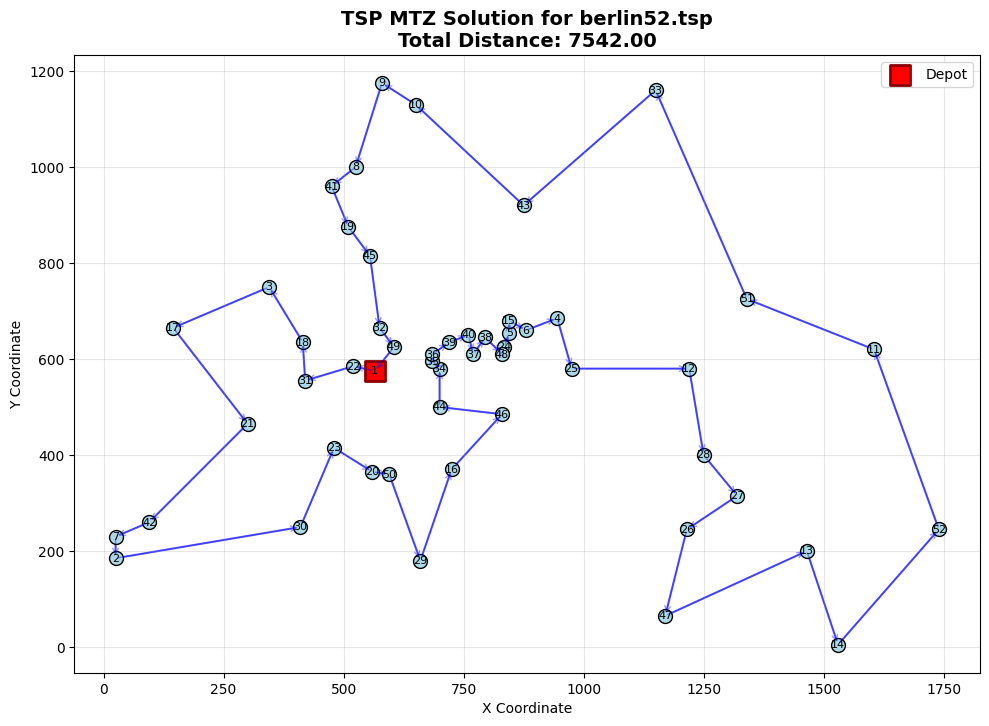

TSP Solution Summary: berlin52
Problem Dimension: 52 nodes
Total Distance: 7542.00

Route (visiting order):
1 -> 29 -> 22 -> 19 -> 49 -> 28 -> 15 -> 45 -> 43 -> 33 -> 34 -> 35 -> 38 -> 39 -> 36 -> 37 -> 47 -> 23 -> 4 -> 14 -> 5 -> 3 -> 24 -> 11 -> 27 -> 26 -> 25 -> 46 -> 12 -> 13 -> 51 -> 10 -> 50 -> 32 -> 42 -> 9 -> 8 -> 7 -> 40 -> 18 -> 44 -> 31 -> 48 -> 0 -> 21 -> 30 -> 17 -> 2 -> 16 -> 20 -> 41 -> 6 -> 1


--- Solving TSP MTZ for lin318.tsp ---

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
Symmetry  2
Presolve  2

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 100808 rows, 101124 columns and 502128 nonzeros
Model fingerprint: 0x6aaa3b62
Variable types: 318 continuous, 100806 integer (100806 binary)
Coefficient st

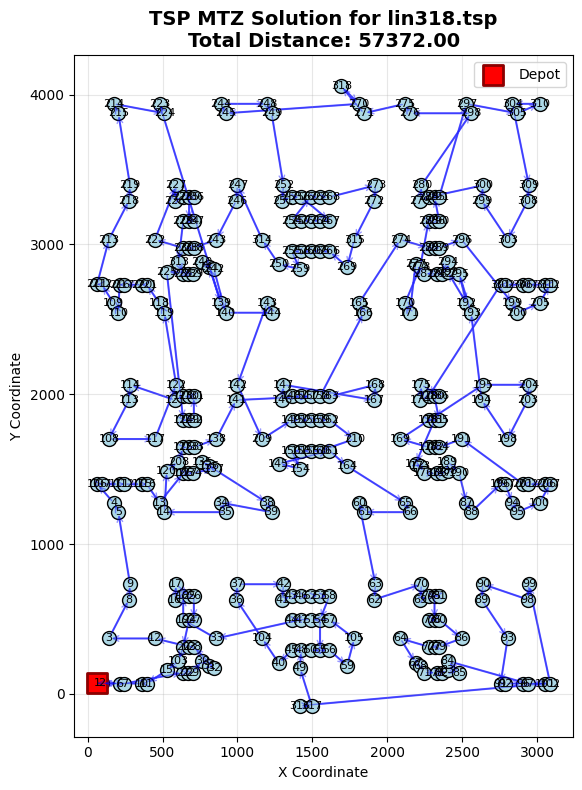

TSP Solution Summary: lin318
Problem Dimension: 318 nodes
Total Distance: 57372.00

Route (visiting order):
1 -> 0 -> 5 -> 6 -> 20 -> 21 -> 28 -> 29 -> 30 -> 31 -> 27 -> 22 -> 11 -> 2 -> 7 -> 8 -> 4 -> 3 -> 105 -> 106 -> 110 -> 111 -> 114 -> 115 -> 12 -> 125 -> 126 -> 133 -> 136 -> 135 -> 134 -> 37 -> 38 -> 33 -> 34 -> 13 -> 119 -> 207 -> 124 -> 127 -> 132 -> 137 -> 140 -> 156 -> 150 -> 147 -> 145 -> 146 -> 166 -> 167 -> 162 -> 157 -> 165 -> 164 -> 273 -> 281 -> 286 -> 288 -> 295 -> 198 -> 199 -> 204 -> 311 -> 310 -> 306 -> 305 -> 301 -> 300 -> 178 -> 173 -> 174 -> 185 -> 179 -> 184 -> 177 -> 180 -> 171 -> 172 -> 175 -> 182 -> 186 -> 187 -> 188 -> 189 -> 86 -> 87 -> 195 -> 196 -> 93 -> 94 -> 99 -> 206 -> 205 -> 201 -> 200 -> 190 -> 183 -> 181 -> 176 -> 168 -> 194 -> 203 -> 202 -> 197 -> 193 -> 192 -> 294 -> 191 -> 292 -> 293 -> 291 -> 287 -> 280 -> 276 -> 170 -> 169 -> 277 -> 282 -> 285 -> 289 -> 284 -> 290 -> 296 -> 304 -> 309 -> 303 -> 308 -> 307 -> 302 -> 298 -> 299 -> 283 -> 278 ->

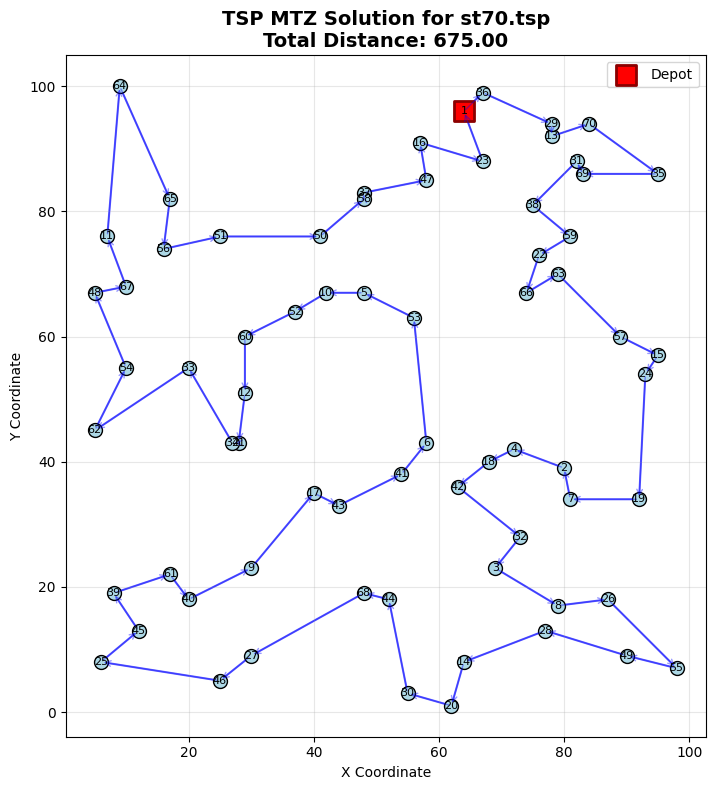

TSP Solution Summary: st70
Problem Dimension: 70 nodes
Total Distance: 675.00

Route (visiting order):
1 -> 3 -> 17 -> 41 -> 31 -> 2 -> 7 -> 25 -> 54 -> 48 -> 27 -> 13 -> 19 -> 29 -> 43 -> 67 -> 26 -> 45 -> 24 -> 44 -> 38 -> 60 -> 39 -> 8 -> 16 -> 42 -> 40 -> 5 -> 52 -> 4 -> 9 -> 51 -> 59 -> 11 -> 20 -> 33 -> 32 -> 61 -> 53 -> 47 -> 66 -> 10 -> 63 -> 64 -> 55 -> 50 -> 49 -> 57 -> 36 -> 46 -> 15 -> 22 -> 0 -> 35 -> 28 -> 12 -> 69 -> 34 -> 68 -> 30 -> 37 -> 58 -> 21 -> 65 -> 62 -> 56 -> 14 -> 23 -> 18 -> 6 -> 1


--- Solving TSP MTZ for ts225.tsp ---

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
Symmetry  2
Presolve  2

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 50402 rows, 50625 columns and 250656 nonzeros
Model f

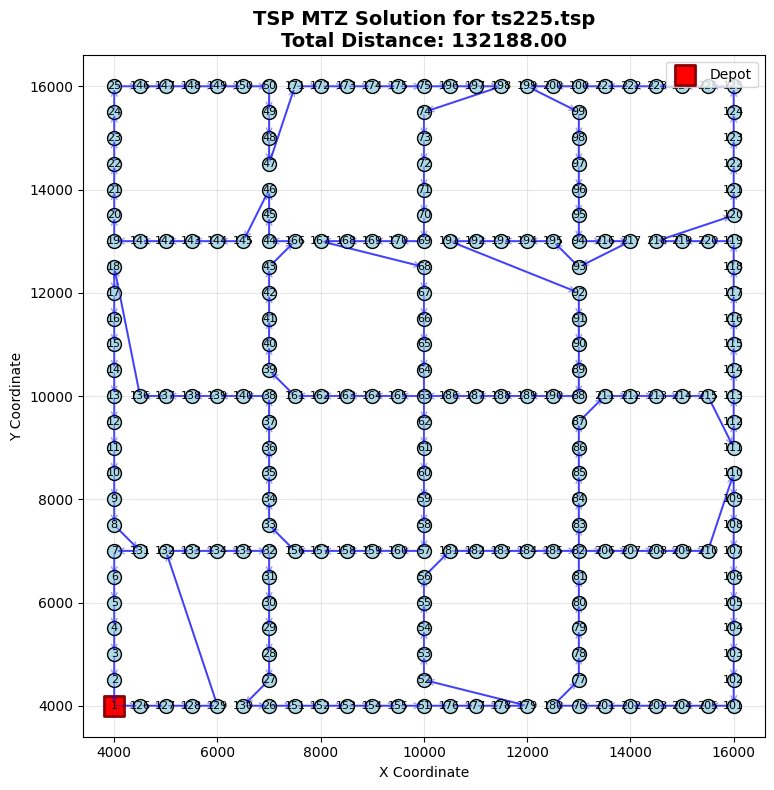

TSP Solution Summary: ts225
Problem Dimension: 225 nodes
Total Distance: 132188.00

Route (visiting order):
1 -> 0 -> 125 -> 126 -> 127 -> 128 -> 131 -> 132 -> 133 -> 134 -> 31 -> 30 -> 29 -> 28 -> 27 -> 26 -> 129 -> 25 -> 150 -> 151 -> 152 -> 153 -> 154 -> 50 -> 175 -> 176 -> 177 -> 178 -> 51 -> 52 -> 53 -> 54 -> 55 -> 180 -> 181 -> 182 -> 183 -> 184 -> 81 -> 205 -> 206 -> 207 -> 208 -> 209 -> 109 -> 108 -> 107 -> 106 -> 105 -> 104 -> 103 -> 102 -> 101 -> 100 -> 204 -> 203 -> 202 -> 201 -> 200 -> 75 -> 179 -> 76 -> 77 -> 78 -> 79 -> 80 -> 82 -> 83 -> 84 -> 85 -> 86 -> 210 -> 211 -> 212 -> 213 -> 214 -> 110 -> 111 -> 112 -> 113 -> 114 -> 115 -> 116 -> 117 -> 118 -> 219 -> 218 -> 217 -> 119 -> 120 -> 121 -> 122 -> 123 -> 124 -> 224 -> 223 -> 222 -> 221 -> 220 -> 99 -> 199 -> 198 -> 98 -> 97 -> 96 -> 95 -> 94 -> 93 -> 215 -> 216 -> 92 -> 194 -> 193 -> 192 -> 191 -> 190 -> 91 -> 90 -> 89 -> 88 -> 87 -> 189 -> 188 -> 187 -> 186 -> 185 -> 62 -> 164 -> 163 -> 162 -> 161 -> 160 -> 38 -> 39 ->

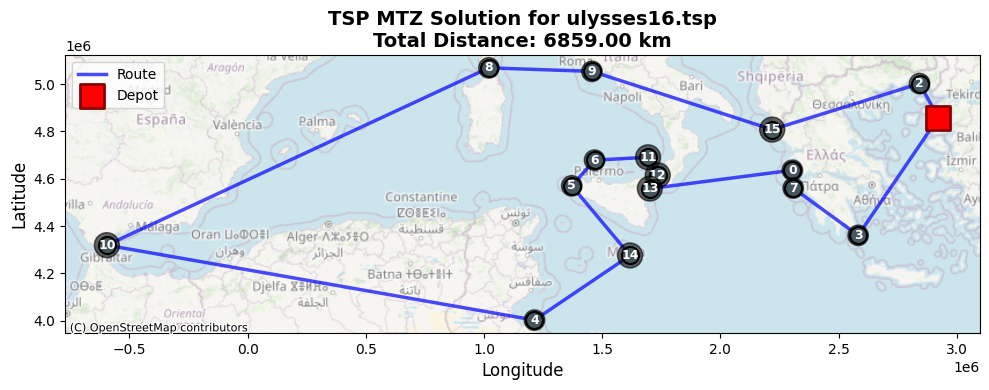

TSP Solution Summary: ulysses16.tsp
Problem Dimension: 16 nodes
Total Distance: 6859.00

Route (visiting order):
1 -> 3 -> 7 -> 0 -> 13 -> 12 -> 11 -> 6 -> 5 -> 14 -> 4 -> 10 -> 8 -> 9 -> 15 -> 2 -> 1


--- Solving TSP MTZ for ulysses22.tsp ---

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
Symmetry  2
Presolve  2

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 464 rows, 484 columns and 2184 nonzeros
Model fingerprint: 0xe97cea59
Variable types: 22 continuous, 462 integer (462 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+01, 3e+03]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.01s
Presolved: 464 row

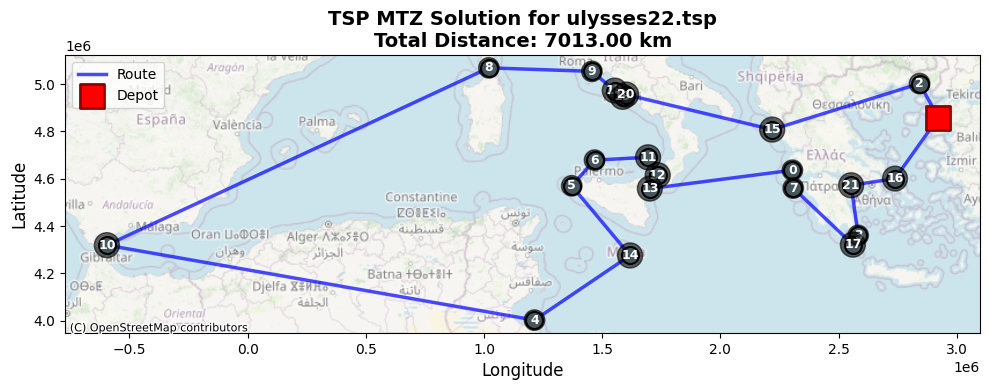

TSP Solution Summary: ulysses22.tsp
Problem Dimension: 22 nodes
Total Distance: 7013.00

Route (visiting order):
1 -> 16 -> 21 -> 3 -> 17 -> 7 -> 0 -> 13 -> 12 -> 11 -> 6 -> 5 -> 14 -> 4 -> 10 -> 8 -> 9 -> 18 -> 19 -> 20 -> 15 -> 2 -> 1


In [67]:
grb_params = {
    "TimeLimit": 300,
    "Presolve":  2,
    "Symmetry":  2,
    # "Threads": 0,        # uncomment to use all cores explicitly
    # "MIPFocus": 1,
    # "Heuristics": 0.25,
    # "Cuts": 2,
    # "Method": 1,         # Dual simplex
    # "Crossover": 0,
    # "NodefileStart": 0.5,
    # "ConcurrentMIP": 2,
}

with pyo.SolverFactory('gurobi_persistent', manage_env=True) as solver:
    # Attach license + params once; reused for all instances
    solver.options.update(WLS)
    solver.options.update(grb_params)

    for problem in PROBLEMS:
        try:
            print(f'\n\n--- Solving TSP MTZ for {problem} ---\n')

            # --- Parse + build ---
            data = parse_tsplib(f'Core/{problem}', build_dist=True)
            model = build_tsp_mtz(data['dist'])

            # --- Load model into persistent solver and solve ---
            solver.set_instance(model)
            results = solver.solve(tee=True)

            term = results.solver.termination_condition
            if term == pyo.TerminationCondition.optimal:
                print(f"✅ Optimal solution found for {problem}")
            else:
                print(f"⚠️ Solver termination: {term}")

            # --- Post-process ---
            plot_tsp_solution(data, model, title=f'TSP MTZ Solution for {problem}', start_node=1)
            print_route_summary(data, model, start_node=1)

        except Exception as e:
            print(f"❌ Error occurred while processing {problem}: {e}")

# Problem 2

## Theory

The Dantzig-Fulkerson-Johnson (DFJ) is almost identical to the (MTZ) formulation for the standard TSP problem with 1 cycle. They only differ in how they handle the subtour elimination, DFJ handles it with the following constrain instead:
$$
\sum_{i\in Q}^{n}\sum_{j\in Q,\\ i\neq j}^{n} x_{i,j} \leq |Q|-1 \quad \forall Q \subseteq\{1,\ldots,n\},|Q|\geq 2\\
$$
This constraint can be interpreted as constraint makes it impossible for any subtour to exist by constraining all possible subcycles to have one less edge than needed for a valid subcycle, if we have 5 nodes then only if we have 5 edges can we form a cycle so with one less we can only have a path through the subset. Observe that we thus do not need to introduce the variable $u$ with the drawback of needing to create a lot of constrain instead, also like the MTZ we omit the node 0 at the origin for the subtour elimination, this is because including 0 would make it imposible as it in itself is a subtour so in another sense by omiting we are only allowing the subtour that goes through all the points. But luckily many of these constraint will not be active so finding cuts should not be too difficult.
$$
\min_{x} \sum_{i=0}^{n}\sum_{j=0,\\ i\neq j}^{n} c_{i,j} x_{i,j} \\
s.t \\
\sum_{i=0, i\neq j}^{n} x_{i,j} = 1 \quad (j = 0,\ldots,n) \quad \text{Inflow constraint} \\
\sum_{j=0, j\neq i}^{n} x_{i,j} = 1 \quad (i = 0,\ldots,n) \quad \text{Outflow constraint} \\
\sum_{i\in Q}^{n}\sum_{j\in Q,\\ i\neq j}^{n} x_{i,j} \leq |Q|-1 \quad \forall Q \subseteq\{1,\ldots,n\},|Q|\geq 2\\
x_{i,j} \in \{0,1\} \quad \forall i,j\\
$$

## Code

In [68]:
def build_tsp_dfj_bad(dist) -> pyo.Model:
    """
    Pyomo DFJ TSP model (depot = 0), with clean domains.
    Args:
        dist: square distance/cost matrix (n x n), indexed 0..n-1
    Returns:
        pyo.Model
    """
    n = len(dist)
    m = pyo.ConcreteModel()

    # --- Sets (domains) ---
    m.V   = pyo.Set(initialize=range(n), ordered=True)                # all nodes {0..n-1}
    #m.Vnd = pyo.Set(initialize=range(1, n), ordered=True)             # non-depot nodes {1..n-1}
    m.A   = pyo.Set(dimen=2, initialize=[(i, j) for i in range(n) for j in range(n) if i != j])

    # --- Parameters (lambda-based initializer) ---
    m.c = pyo.Param(m.A, initialize=lambda m, i, j: float(dist[i][j]), within=pyo.NonNegativeReals)

    # --- Decision variables ---
    m.x = pyo.Var(m.A, within=pyo.Binary)   # arc selection

    # --- Objective ---
    m.obj = pyo.Objective(expr=sum(m.c[i, j] * m.x[i, j] for (i, j) in m.A), sense=pyo.minimize)

    # --- Degree constraints (enter once, leave once) ---
    m.outdeg = pyo.Constraint(m.V, rule=lambda m, i: sum(m.x[i, j] for j in m.V if j != i) == 1)
    m.indeg  = pyo.Constraint(m.V, rule=lambda m, j: sum(m.x[i, j] for i in m.V if i != j) == 1)

    # --- Subtour elimination ---
    m.subtour = pyo.ConstraintList()
    for k in range(2, n):
        for S in itertools.combinations(range(n), k):
            m.subtour.add(sum(m.x[i,j] for i in S for j in S if i != j) <= len(S) - 1)

    return m



--- Solving TSP DFJ for ulysses16.tsp ---

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2707350
Set parameter TimeLimit to value 300
Set parameter Symmetry to value 2
Set parameter Cuts to value 2
Set parameter Presolve to value 2
Academic license 2707350 - for non-commercial use only - registered to an___@kth.se


Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
Symmetry  2
Cuts  2
Presolve  2

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 65550 rows, 240 columns and 3932400 nonzeros
Model fingerprint: 0x4dc8f03a
Variable types: 0 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 14369.000000
Presolve removed 0 rows and 0 columns (presolve time = 5s)...
Presolve time: 5.02s
Presolved: 65550 rows, 240 columns, 3932400 nonzeros
Variable types: 0 continuous, 240 integer (240 binary)
Root relaxation presolve removed 1 rows and 0 columns
Root relaxation p

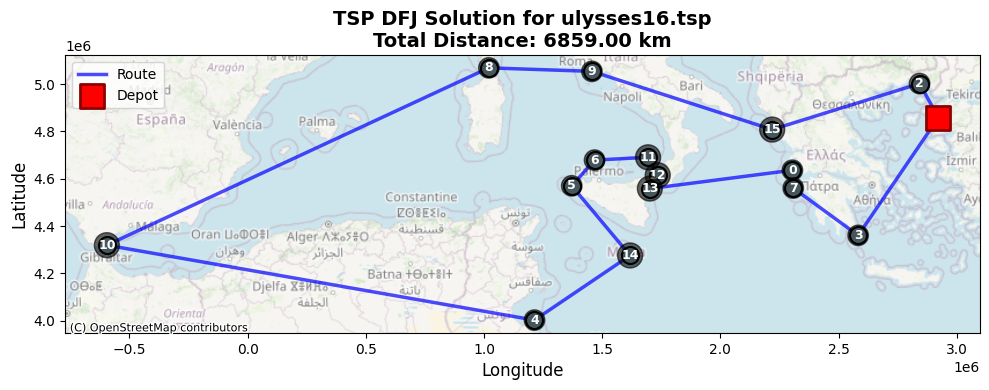

TSP Solution Summary: ulysses16.tsp
Problem Dimension: 16 nodes
Total Distance: 6859.00

Route (visiting order):
1 -> 3 -> 7 -> 0 -> 13 -> 12 -> 11 -> 6 -> 5 -> 14 -> 4 -> 10 -> 8 -> 9 -> 15 -> 2 -> 1


In [69]:
grb_params = {
    "TimeLimit": 300,
    "Presolve":  2,
    "Symmetry":  2,
    "Cuts": 2,
}

with pyo.SolverFactory("gurobi_persistent", manage_env=True) as solver:
    solver.options.update(WLS)
    solver.options.update(grb_params) 

    for problem in [PROBLEMS[-2]]:
        print(f"\n\n--- Solving TSP DFJ for {problem} ---\n")
        data  = parse_tsplib(f'Core/{problem}', build_dist=True)
        model = build_tsp_dfj_bad(data['dist'])

        solver.set_instance(model)
        results = solver.solve(tee=True)

        term = results.solver.termination_condition
        print("✅ Optimal" if term == pyo.TerminationCondition.optimal else f"⚠️ Termination: {term}")

        # depot is 0 in your model; keep plotting consistent
        plot_tsp_solution(data, model, title=f'TSP DFJ Solution for {problem}', start_node=1)
        print_route_summary(data, model, start_node=1)


# Problem 3

## Code

In [ ]:
def build_tsp_dfj(dist) -> pyo.Model:
    """
    Pyomo DFJ TSP model with lazy constraint support.
    """
    n = len(dist)
    m = pyo.ConcreteModel()

    # Sets
    m.V = pyo.Set(initialize=range(n), ordered=True)
    m.A = pyo.Set(dimen=2, initialize=[(i, j) for i in range(n) for j in range(n) if i != j])

    # Parameters
    m.c = pyo.Param(m.A, initialize=lambda m, i, j: float(dist[i][j]), within=pyo.NonNegativeReals)

    # Variables
    m.x = pyo.Var(m.A, within=pyo.Binary)

    # Objective
    m.obj = pyo.Objective(expr=sum(m.c[i, j] * m.x[i, j] for (i, j) in m.A), sense=pyo.minimize)

    # Degree constraints
    m.outdeg = pyo.Constraint(m.V, rule=lambda m, i: sum(m.x[i, j] for j in m.V if j != i) == 1)
    m.indeg = pyo.Constraint(m.V, rule=lambda m, j: sum(m.x[i, j] for i in m.V if i != j) == 1)

    # Constraint list for lazy cuts
    m.subtour_cuts = pyo.ConstraintList()

    return m

def _find_subtours(n, succ):
    """Find all subtours in the current solution."""
    visited = [False] * n
    subtours = []
    
    for start in range(n):
        if visited[start]:
            continue
        
        tour = []
        node = start
        while not visited[node]:
            visited[node] = True
            tour.append(node)
            if node not in succ:
                break
            node = succ[node]
        
        # Only consider it a subtour if it's a cycle and doesn't include depot (node 0)
        if len(tour) > 1 and node == start and 0 not in tour:
            subtours.append(tour)
    
    return subtours

def my_callback(cb_m, cb_opt, cb_where):
    """
    Callback for subtour elimination using lazy constraints.
    cb_m: the model
    cb_opt: the persistent solver
    cb_where: callback location (GRB.Callback.MIPSOL, etc.)
    """
    if cb_where != GRB.Callback.MIPSOL:
        return
    
    # Get solution values for all x variables
    cb_opt.cbGetSolution(vars=list(cb_m.x.values()))
    
    # Build successor map from solution
    n = len(cb_m.V)
    succ = {}
    for (i, j) in cb_m.A:
        if cb_m.x[i, j].value > 0.5:
            succ[i] = j
    
    # Find subtours
    subtours = _find_subtours(n, succ)
    
    if subtours:
        print(f"Found {len(subtours)} subtour(s), adding cuts...")
        for S in subtours:
            # Add DFJ cut: sum of edges within S <= |S| - 1
            cut_expr = sum(cb_m.x[i, j] for i in S for j in S if i != j and (i, j) in cb_m.A)
            cb_opt.cbLazy(cb_m.subtour_cuts.add(cut_expr <= len(S) - 1))
            #print(f"  Cut added for subtour of size {len(S)}: {S[:5]}{'...' if len(S) > 5 else ''}")



--- Solving TSP DFJ with Lazy Constraints for berlin52.tsp ---

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2707350
Set parameter TimeLimit to value 300
Set parameter Symmetry to value 2
Set parameter Cuts to value 2
Set parameter PreCrush to value 1
Set parameter Presolve to value 2
Set parameter LazyConstraints to value 1
Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
Symmetry  2
Cuts  2
PreCrush  1
Presolve  2
LazyConstraints  1

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 104 rows, 2652 columns and 5304 nonzeros
Model fingerprint: 0xf5207cb0
Variable types: 0 continuous, 2652 integer (2652

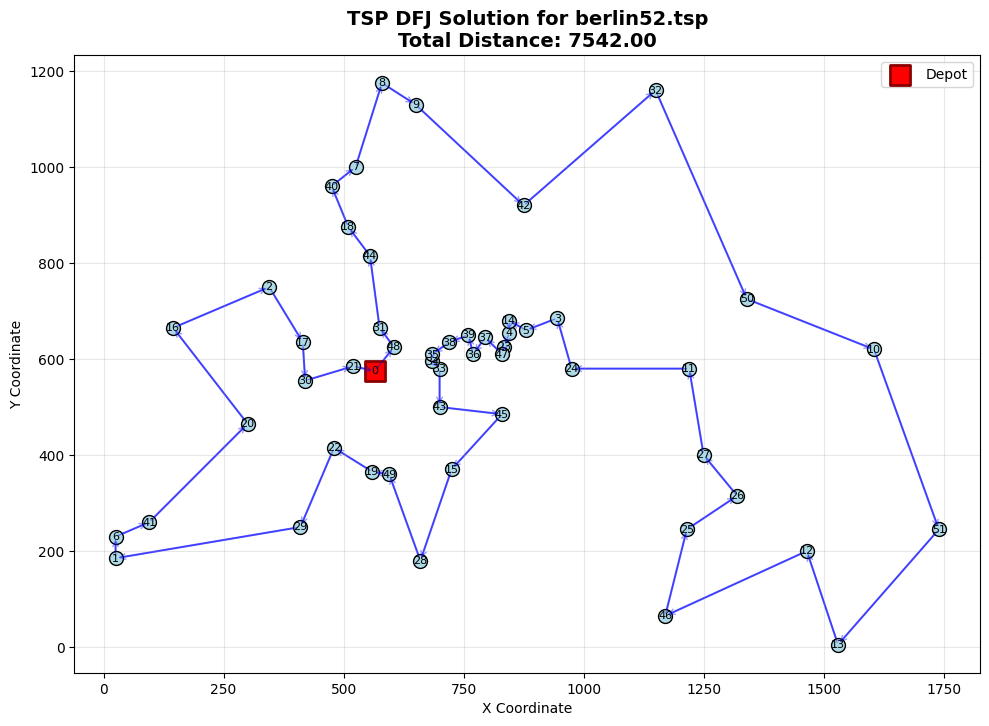

TSP Solution Summary: berlin52
Problem Dimension: 52 nodes
Total Distance: 7542.00

Route (visiting order):
0 -> 48 -> 31 -> 44 -> 18 -> 40 -> 7 -> 8 -> 9 -> 42 -> 32 -> 50 -> 10 -> 51 -> 13 -> 12 -> 46 -> 25 -> 26 -> 27 -> 11 -> 24 -> 3 -> 5 -> 14 -> 4 -> 23 -> 47 -> 37 -> 36 -> 39 -> 38 -> 35 -> 34 -> 33 -> 43 -> 45 -> 15 -> 28 -> 49 -> 19 -> 22 -> 29 -> 1 -> 6 -> 41 -> 20 -> 16 -> 2 -> 17 -> 30 -> 21 -> 0


--- Solving TSP DFJ with Lazy Constraints for lin318.tsp ---

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
Symmetry  2
Cuts  2
PreCrush  1
Presolve  2
LazyConstraints  1

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 636 rows, 100806 columns and 201612 nonzeros
Model fingerprint: 0x208c40b3
Variable types: 0 c

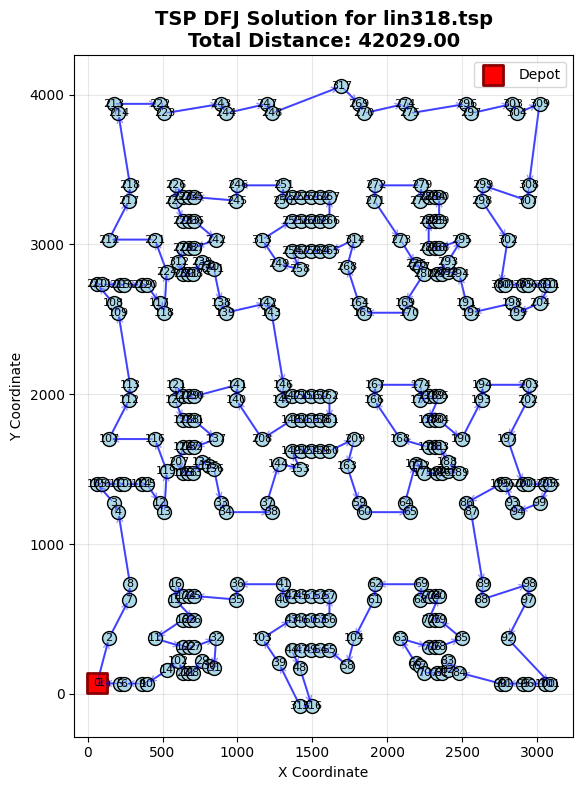

TSP Solution Summary: lin318
Problem Dimension: 318 nodes
Total Distance: 42029.00

Route (visiting order):
0 -> 2 -> 7 -> 8 -> 4 -> 3 -> 105 -> 106 -> 110 -> 111 -> 114 -> 115 -> 12 -> 13 -> 119 -> 116 -> 107 -> 112 -> 113 -> 109 -> 108 -> 210 -> 211 -> 215 -> 216 -> 219 -> 220 -> 117 -> 118 -> 224 -> 221 -> 212 -> 217 -> 218 -> 214 -> 213 -> 222 -> 223 -> 243 -> 244 -> 247 -> 248 -> 317 -> 269 -> 270 -> 274 -> 275 -> 296 -> 297 -> 303 -> 304 -> 309 -> 308 -> 307 -> 299 -> 298 -> 302 -> 300 -> 301 -> 305 -> 306 -> 310 -> 311 -> 204 -> 199 -> 198 -> 192 -> 191 -> 294 -> 292 -> 291 -> 287 -> 293 -> 295 -> 288 -> 286 -> 281 -> 282 -> 285 -> 289 -> 290 -> 284 -> 283 -> 278 -> 279 -> 272 -> 271 -> 273 -> 276 -> 277 -> 280 -> 169 -> 170 -> 165 -> 164 -> 268 -> 314 -> 265 -> 264 -> 259 -> 257 -> 254 -> 258 -> 249 -> 313 -> 253 -> 256 -> 260 -> 263 -> 266 -> 267 -> 262 -> 261 -> 255 -> 252 -> 250 -> 251 -> 246 -> 245 -> 235 -> 234 -> 227 -> 226 -> 225 -> 228 -> 233 -> 236 -> 242 -> 237 -> 232

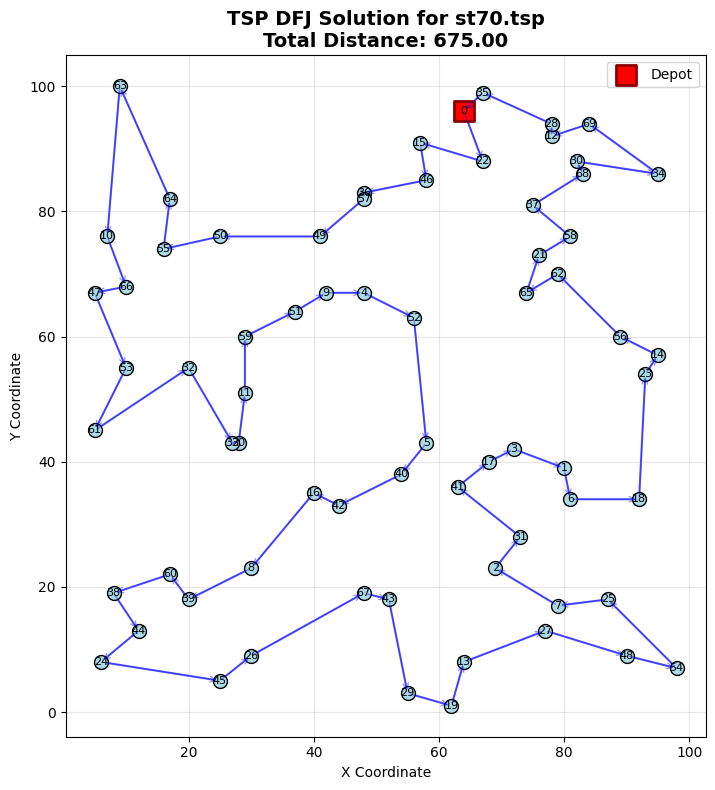

TSP Solution Summary: st70
Problem Dimension: 70 nodes
Total Distance: 675.00

Route (visiting order):
0 -> 22 -> 15 -> 46 -> 36 -> 57 -> 49 -> 50 -> 55 -> 64 -> 63 -> 10 -> 66 -> 47 -> 53 -> 61 -> 32 -> 33 -> 20 -> 11 -> 59 -> 51 -> 9 -> 4 -> 52 -> 5 -> 40 -> 42 -> 16 -> 8 -> 39 -> 60 -> 38 -> 44 -> 24 -> 45 -> 26 -> 67 -> 43 -> 29 -> 19 -> 13 -> 27 -> 48 -> 54 -> 25 -> 7 -> 2 -> 31 -> 41 -> 17 -> 3 -> 1 -> 6 -> 18 -> 23 -> 14 -> 56 -> 62 -> 65 -> 21 -> 58 -> 37 -> 68 -> 30 -> 34 -> 69 -> 12 -> 28 -> 35 -> 0


--- Solving TSP DFJ with Lazy Constraints for ts225.tsp ---

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
Symmetry  2
Cuts  2
PreCrush  1
Presolve  2
LazyConstraints  1

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a mod

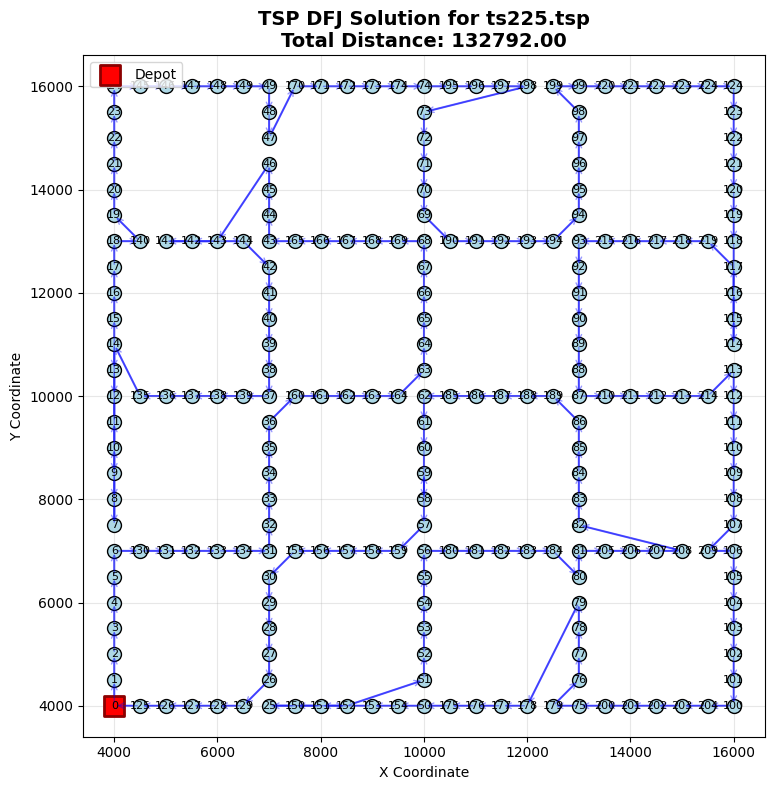

TSP Solution Summary: ts225
Problem Dimension: 225 nodes
Total Distance: 132792.00

Route (visiting order):
0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 130 -> 131 -> 132 -> 133 -> 134 -> 31 -> 32 -> 33 -> 34 -> 35 -> 36 -> 160 -> 161 -> 162 -> 163 -> 164 -> 63 -> 64 -> 65 -> 66 -> 67 -> 68 -> 169 -> 168 -> 167 -> 166 -> 165 -> 43 -> 44 -> 45 -> 46 -> 143 -> 142 -> 141 -> 144 -> 42 -> 41 -> 40 -> 39 -> 38 -> 37 -> 139 -> 138 -> 137 -> 136 -> 135 -> 14 -> 13 -> 12 -> 9 -> 8 -> 7 -> 10 -> 11 -> 15 -> 16 -> 17 -> 18 -> 140 -> 19 -> 20 -> 21 -> 22 -> 23 -> 24 -> 145 -> 146 -> 147 -> 148 -> 149 -> 49 -> 48 -> 47 -> 170 -> 171 -> 172 -> 173 -> 174 -> 74 -> 195 -> 196 -> 197 -> 198 -> 73 -> 72 -> 71 -> 70 -> 69 -> 190 -> 191 -> 192 -> 193 -> 194 -> 94 -> 95 -> 96 -> 97 -> 98 -> 199 -> 99 -> 220 -> 221 -> 222 -> 223 -> 224 -> 124 -> 123 -> 122 -> 121 -> 120 -> 119 -> 118 -> 114 -> 115 -> 116 -> 117 -> 219 -> 218 -> 217 -> 216 -> 215 -> 93 -> 92 -> 91 -> 90 -> 89 -> 88 -> 87 -> 210 -> 211 -> 212 -> 213 -

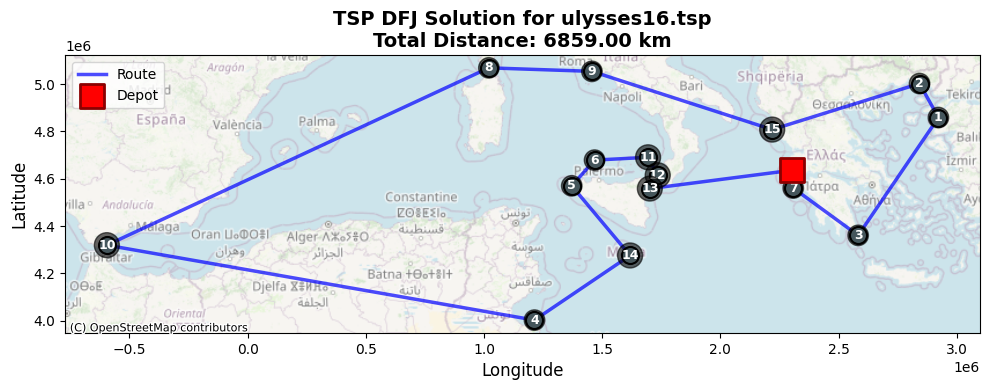

TSP Solution Summary: ulysses16.tsp
Problem Dimension: 16 nodes
Total Distance: 6859.00

Route (visiting order):
0 -> 13 -> 12 -> 11 -> 6 -> 5 -> 14 -> 4 -> 10 -> 8 -> 9 -> 15 -> 2 -> 1 -> 3 -> 7 -> 0


--- Solving TSP DFJ with Lazy Constraints for ulysses22.tsp ---

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
Symmetry  2
Cuts  2
PreCrush  1
Presolve  2
LazyConstraints  1

Academic license 2707350 - for non-commercial use only - registered to an___@kth.se
Optimize a model with 44 rows, 462 columns and 924 nonzeros
Model fingerprint: 0xe2dd4a65
Variable types: 0 continuous, 462 integer (462 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found 2 subtour(s),

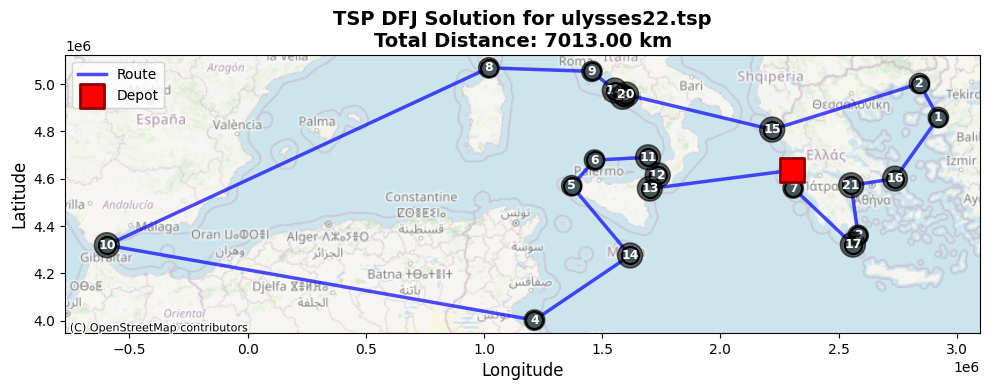

TSP Solution Summary: ulysses22.tsp
Problem Dimension: 22 nodes
Total Distance: 7013.00

Route (visiting order):
0 -> 7 -> 17 -> 3 -> 21 -> 16 -> 1 -> 2 -> 15 -> 20 -> 19 -> 18 -> 9 -> 8 -> 10 -> 4 -> 14 -> 5 -> 6 -> 11 -> 12 -> 13 -> 0


In [73]:
grb_params = {
    "TimeLimit": 300,
    "Presolve":  2,
    "Symmetry":  2,
    "Cuts": 2,
    "LazyConstraints": 1,
    "PreCrush": 1,
}

with pyo.SolverFactory("gurobi_persistent", manage_env=True) as solver:
    solver.options.update(WLS)
    solver.options.update(grb_params)

    for problem in PROBLEMS:  # Test with ulysses16 first
        try:
            print(f"\n\n--- Solving TSP DFJ with Lazy Constraints for {problem} ---\n")
            data = parse_tsplib(f"Core/{problem}", build_dist=True)
            model = build_tsp_dfj(data["dist"])

            # Set up solver with callback
            solver.set_instance(model)
            solver.set_callback(my_callback)
            
            # Solve
            results = solver.solve(tee=True)

            term = results.solver.termination_condition
            print("✅ Optimal" if term == pyo.TerminationCondition.optimal 
                  else f"⚠️ Termination: {term}")

            plot_tsp_solution(data, model, title=f"TSP DFJ Solution for {problem}", start_node=0)
            print_route_summary(data, model, start_node=0)

        except Exception as e:
            print(f"❌ Error occurred while processing {problem}: {e}")
            import traceback
            traceback.print_exc()